# 베이즈 정리

사건  $B$ 가 발생함으로써(즉, 사건  $B$ 의 확률  $P(B)=1$ 이라는 것을 알게 됨으로써) 사건  $A$ 의 확률이 어떻게 변화하는지를 표현한 정리

$$
P(A|B) = \dfrac{P(B|A)P(A)}{P(B)}
$$

(증명)

$ P(A|B) = \dfrac{P(A,B)}{P(B)} \;\; \rightarrow \;\; P(A,B) = P(A|B)P(B) $

$ P(A|B) = \dfrac{P(A,B)}{P(B)} \;\; \rightarrow \;\; P(A,B) = P(A|B)P(B) $

$P(A,B) = P(A|B)P(B) = P(B|A)P(A)$

$P(A|B) = \dfrac{P(B|A)P(A)}{P(B)}$

- $P(A|B)$ : 사후 확률(posterior). 사건 B가 발생한 후 갱신된 사건 A의 확률
- $P(A)$ : 사전 확률(prior). 사건 B가 발생하기 전에 가지고 있던 사건 A의 확률
- $P(B|A)$ : likelihood. 사건 A가 발생한 경우 사건 B의 확률
- $P(B)$ : 정규화 상수(normalizing constant): 확률의 크기 조정

## 베이즈 정리의 확장 1

$A_1=A ,\;  A_2=A^C$  인 경우에는 다음과 같다.

$
\begin{eqnarray}
P(A|B) 
&=& \dfrac{P(B|A)P(A)}{P(B)} \\
&=& \dfrac{P(B|A)P(A)}{P(B,A) + P(B,A^C)} \\
&=& \dfrac{P(B|A)P(A)}{P(B|A)P(A) + P(B|A^C)P(A^C)} \\
&=& \dfrac{P(B|A)P(A)}{P(B|A)P(A) + P(B|A^C)(1 - P(A))} 
\end{eqnarray}
$

## pgmpy을 사용한 베이즈 정리 적용

In [1]:
!pip3 install wrapt

In [2]:
from pgmpy.factors.discrete import TabularCPD

확률 변수 X를 이용하여 병에 걸렸을 확률  $P(D)=P(X=1)$, 병에 걸리지 않았을 확률  $P(D^C)=P(X=0)$ 를 정의한다.

In [3]:
cpd_X = TabularCPD('X', 2, [[1 - 0.002, 0.002]])
print(cpd_X)

╒═════╤═══════╕
│ X_0 │ 0.998 │
├─────┼───────┤
│ X_1 │ 0.002 │
╘═════╧═══════╛


다음으로 확률 변수 Y를 이용하여 양성 반응이 나올 확률  $P(S)=P(Y=1)$ , 음성 반응이 나올 확률  $P(S^C)=P(Y=0)$ 를 정의한다. 

이 확률은 병에 걸렸는가 걸리지 않았는가에 따라 달라지므로 다음처럼 조건부로 정의한다.

$
P(S|D) = 0.99,\; P(S^C|D) = 0.01 \\
P(S|D^C) = 0.05,\; P(S^C|D^C) = 0.95
$

In [4]:
cpd_YX = TabularCPD('Y', 2, np.array([[0.95, 0.01], [0.05, 0.99]]),
                    evidence=['X'], evidence_card=[2])
print(cpd_YX)

╒═════╤══════╤══════╕
│ X   │ X_0  │ X_1  │
├─────┼──────┼──────┤
│ Y_0 │ 0.95 │ 0.01 │
├─────┼──────┼──────┤
│ Y_1 │ 0.05 │ 0.99 │
╘═════╧══════╧══════╛


In [5]:
from pgmpy.models import BayesianModel

model = BayesianModel([('X', 'Y')])
model.add_cpds(cpd_X, cpd_YX)
model.check_model()

True

In [6]:
from pgmpy.inference import VariableElimination

infer = VariableElimination(model)
posterior = infer.query(['X'], evidence={'Y': 1})
print(posterior['X'])

╒═════╤══════════╕
│ X   │   phi(X) │
╞═════╪══════════╡
│ X_0 │   0.9618 │
├─────┼──────────┤
│ X_1 │   0.0382 │
╘═════╧══════════╛


$P(D|S)=0.038$

## 베이즈 정리의 확장 2

### <연습 문제 1>
다음 식을 증명하라.

$$
P(A|B,C) = \dfrac{P(B|A,C)P(A|C)}{P(B|C)}
$$

(증명)

$
P(A,B,C) = P(A|B,C)P(B,C) = P(A|B,C)P(B|C)P(C) \\ 
P(A,B,C) = P(B|A,C)P(A,C) = P(B|A,C)P(A|C)P(C) \\ 
P(A|B,C)P(B|C)P(C) = P(B|A,C)P(A|C)P(C) \\ 
P(A|B,C) = \dfrac{P(B|A,C)P(A|C)}{P(B|C)}
$

# 베이즈 정리와 분류 문제
베이즈 정리는 머신 러닝 중 분류(classification) 문제를 해결하는데 사용될 수 있다. 

분류 문제는 입력 자료  $X$ 의 값으로부터 카테고리 값인 출력 자료  $Y$ 의 값을 예측(prediction)하는 문제이다. 

## 과일 선택 문제
- 어떤 과일 가게에서 사과와 오렌지를  Red 농장과 Blue 농장에서 공급 받고 있다.
- Red 농장에서 붉은 상자에 사과 2개, 오렌지 6개를 담아서 보냈다. 
- Blue 농장에서는 푸른 상자에 사과가 3, 오렌지가 1개를 담아서 공급했다.
- 어떤 손님이 와서 오렌지를 하나 선택했다( $X = O$ ). 
- 이 오렌지는 Red 농장에서 온 것일까( $Y = R$ ), 아니면 Blue 농장에서 온 것일까( $Y = B$ )?
- 손님이 오렌지를 선택한 경우에 원산지가 Red 농장일 확률( $P(R|O)$ )을 구하여라.

In [7]:
from pgmpy.factors.discrete import TabularCPD

확률 변수 Y를 Y=0인 경우가 Red 농장, Y=1인 경우가 Blue 농장으로 정의한다.

In [8]:
cpd_Y = TabularCPD('Y', 2, [[8/12, 4/12]])
print(cpd_Y)

╒═════╤══════════╕
│ Y_0 │ 0.666667 │
├─────┼──────────┤
│ Y_1 │ 0.333333 │
╘═════╧══════════╛


확률 변수 X는 X=0인 경우를 오렌지인 경우, X=1인 경우를 사과인 경우으로 정의한다.

In [9]:
cpd_XY = TabularCPD('X', 2, np.array([[6/8, 1/4], [2/8, 3/4]]),
                    evidence=['Y'], evidence_card=[2])
print(cpd_XY)

╒═════╤══════╤══════╕
│ Y   │ Y_0  │ Y_1  │
├─────┼──────┼──────┤
│ X_0 │ 0.75 │ 0.25 │
├─────┼──────┼──────┤
│ X_1 │ 0.25 │ 0.75 │
╘═════╧══════╧══════╛


In [10]:
from pgmpy.models import BayesianModel

model = BayesianModel([('Y', 'X')])
model.add_cpds(cpd_Y, cpd_XY)
model.check_model()

True

In [11]:
from pgmpy.inference import VariableElimination

infer = VariableElimination(model)
posterior = infer.query(['Y'], evidence={'X': 0})
print(posterior['Y'])

╒═════╤══════════╕
│ Y   │   phi(Y) │
╞═════╪══════════╡
│ Y_0 │   0.8571 │
├─────┼──────────┤
│ Y_1 │   0.1429 │
╘═════╧══════════╛


In [12]:
print(6/7, 1/7)

0.8571428571428571 0.14285714285714285


$P(R|O) = \dfrac{6}{7} $

# 확률 모형

## 데이터와 확률 모형

표본 공간과 확률이 정해져 있으면 이 두 가지를 사용하여 데이터를 생성할 수 있다. 이를 **확률 모형**이라고 부른다. 

확률 모형은 주사위나 자동차 엔진처럼 내가 원하는 시점에 데이터를 생성하는 일종의 기계(machine)라고 생각하면 된다.

데이터를 생성하는 과정을 **샘플링**(sampling) 또는 **실현**(realization)이라고 한다.

## 확률 모형과 실제 데이터의 관계
- 확률 모형으로부터 데이터를 여러번 생성하는 경우, 실제 데이터 값은 매번 달라질 수 있지만 확률 모형 자체는 변하지 않는다.
- 확률 모형은 우리가 직접 관찰할 수 없고, 확률 모형에서 만들어지는 실제 데이터 값을 이용하여 확률 모형이 이러한 것일 거라고 추정하고 가정할 뿐이다.
- 확률 모형에서 만들어 지는 실제 데이터의 값은 확률 모형이 가진 특성을 반영하고 있다.
- 데이터의 갯수가 적을 수록 부정확하여 확률 모형이 가진 특징을 정확하게 추정할 수 없다.

## 데이터 분석의 과정
1. 데이터를 확보한다.
2. 확보된 데이터를 어떤 확률 모형의 표본으로 가정한다.
3. 데이터의 특성으로부터 확률 모형의 특성을 추정한다.
4. 구해진 확률 모형의 특성으로 해당 확률 모형의 종류를 결정하고 모수를 추정한다.
5. 구해진 확률 모형으로부터 다음에 생성될 데이터나 데이터 특성을 예측한다.

# 확률 변수
확률 변수는 표본 공간의 모든 표본에 대해 어떤 실수 값을 붙인 것이다. 

**확률 변수는 표본 공간을 정의역(domain)으로 가지고 실수를 공역(range)으로 가지는 함수라고 할 수 있다.** 

보통  $X ,  Y$  등의 대문자 알파벳을 사용하여 확률 변수를 표기한다. 

확률 변수에 의해 할당된 실수는  $x ,  y$ 와 같이 소문자 알파벳으로 표시한다.

$$
\omega \in \Omega \;\;\; \xrightarrow{X} \;\;\; \text{실수 } x \in \mathbb{R} \\
X(\omega) = x, \;\; x \in \mathbf{R}
$$

## 확률과 확률 변수의 차이점
- 확률은 표본으로 이루어진 집합 즉, 사건에 대해 할당된 숫자이지만/ 확률 변수는 표본 하나 하나에 대해 할당된 숫자이다.
- 확률은 0부터 1사이의 숫자만 할당할 수 있지만/ 확률 변수는 모든 실수 범위의 숫자를 할당할 수 있다.

확률 변수를 사용하면 모든 표본은 하나의 실수 숫자로 변하기 때문에 표본 공간을 실수의 집합 즉, **수직선(number line)**으로 표시할 수 있다. 

일반적인 사건(event)은 이 수직선 상의 구간으로 표시된다.

`확률 변수를 정의한다는 것은 표본(sample)이라는 추상적이고 일반적인 개념대신 숫자라는 명확한 개념을 대신 사용하겠다`는 의미이다.

현실적으로도 계산이 가능한 것은 숫자 뿐이므로 데이터 분석을 수행하기 위해서는 결국 표본의 특성(feature)을 숫자로 변환하는 단계가 필요하다.

## 이산 확률 변수
확률 변수값이 연속적(continuous)이지 않고 떨어져(discrete) 있는 경우를 **이산 확률 변수(discrete random variable)**라고 한다.

## 연속 확률 변수
 실수(real number) 집합처럼 연속적이고 무한개의 경우의 수를 가지는 확률 변수를 **연속 확률 변수 (continuous random variable)**라고 한다.

# 누적 분포 함수와 확률 밀도 함수

## 확률 분포
어떤 사건에 어느 정도의 확률이 할당되었는지를 묘사한 것을 **확률 분포(distribution)**라고 한다.

$$
P(\{ a \leq x < b \}) = P(a, b)
$$

## 누적 분포 함수 (cdf)
확률 분포의 구간의 시작점을 음수 무한대( $−∞$ )로 묘사하는 함수를 

**누적 분포 함수(cumulative distribution function)**라고 하고 약자로 **cdf**라고 쓴다. 

일반적으로 cdf는 대문자를 사용하여  $F(x)$ 와 같은 기호로 표시하며 이 때 독립 변수  $x$ 는 범위의 끝을 뜻한다. 

범위의 시작은 음의 무한대(negative infinity,  $−∞$ )이다.

$$
F(x) = P(\{X < x\})
$$

- $F(−∞)=0$

- $F(+∞)=1$ 

- $F(x)≥F(y) if x>y$

## 확률 밀도 함수 (pdf)
누적 분포 함수는 확률이 어느 사건(event)에 어느 정도 분포되어 있는지 수학적으로 명확하게 표현해 준다.

그러나 `어떤 확률 변수 값이 더 자주 나오는지에 대한 정보`를 알기 힘들다.

이러한 단점을 보완하기 위한 것이 절대적인 확률이 아닌 상대적인 확률 분포 형태만을 보기 위한 **확률 밀도 함수(probability density function)**이다.

확률 밀도 함수는 특정 확률 변수 구간의 확률이 다른 구간에 비해 **상대적으로** 얼마나 높은가를 나타내는 것이며 그 **값 자체가 확률은 아니다**라는 점을 명심해야 한다.

$$
f(x) = \dfrac{dF(x)}{dx} \\ \\
F(x) = \int_{-\infty}^{x} f(u) du
$$

- $−∞$  부터 $∞$ 까지 적분하면 그 값은 1이 된다.
$$\int_{-\infty}^{\infty} f(u)du = 1$$

- 확률 밀도 함수는 0보다 같거나 크다. 
$$f(x) \geq 0$$

## 확률 질량 함수 (pmf)
이산 확률 변수의 가능한 값 하나 하나에 대해 확률을 정의한 함수를 **확률 질량 함수(probability mass funtion)**라고 한다.

확률 질량 함수의 확률 변수에 대해 각 값을 누적하여 더하면 이산 확률 변수의 **누적 분포 함수(cumulative distribution function)**를 구할 수 있다.

# 샘플 평균과 기댓값

## 샘플 평균
유한한 갯수의 자료 값의 집합으로 부터 다음과 같은 식을 사용하여 계산한 값을 샘플 평균이라고 한다.

$$
m = \bar{x} = \dfrac{1}{N}\sum_{i=1}^{N} x_i
$$

- $N$ : 자료의 갯수  
- $i=1,⋯,N$ : 자료의 순서 혹은 인덱스(index)
- $x_i$ : $i$ 번째 자료의 값

자료가 어떤 확률 분포를 따르는 확률 변수  $X$ 의 샘플이라고 가정하자. 이러한 경우에는 확률 변수 위에 bar를 추가하여  $\bar{X}$ 와 같이 샘플 평균을 나타내기도 한다.  

$$
\bar{X} = \dfrac{1}{N}\sum_{i=1}^{N} X_i
$$
- $X_i$ :  $i$ 번째로 실현된 샘플
- 샘플 평균  $\bar{X}$ 도 원래의 확률 변수  $X$ 와 밀접한 관계를 가지는 다른 하나의 확률 변수라고 할 수 있다. 원래의 확률 변수  $X$ 와는 다른 분포 형태를 가진다.

### <연습 문제 1>
1. NumPy를 사용하여 20개의 숫자를 무작위로 생성한 후 히스토그램을 그리고 샘플 평균을 구한다.
2. 1번과 같이 20개의 숫자 생성 및 샘플 평균 계산을 10번 반복하여 10개의 샘플 평균을 구한다.
3. 2번에서 구한 샘플 평균의 히스토그램을 그리고 샘플 평균을 구한다.

샘플 평균 : 59.3


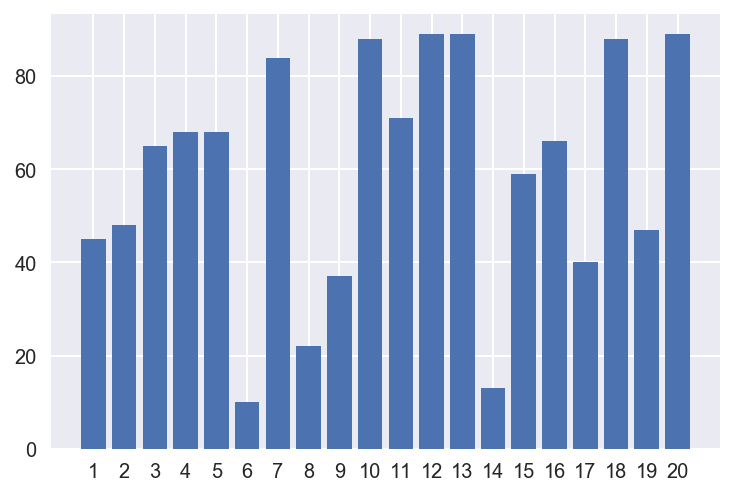

In [54]:
# 1.
x = []
for i in range(1, 21):
    x.append(i)

np.random.seed(0)
y = np.random.randint(1, 100, 20) 
print("샘플 평균 :", np.mean(y))
plt.bar(x, y)
plt.xticks(x)
plt.show()

In [55]:
# 2.
result = []
for i in range(10):
    i += 1
    y = np.random.randint(1, 100, 20)
    y1 = np.mean(y)
    print("샘플 평균", i, ":", y1)
    result.append(y1)   
result = np.array(result)

샘플 평균 1 : 50.95
샘플 평균 2 : 35.95
샘플 평균 3 : 43.4
샘플 평균 4 : 49.65
샘플 평균 5 : 50.25
샘플 평균 6 : 51.9
샘플 평균 7 : 39.15
샘플 평균 8 : 53.8
샘플 평균 9 : 50.9
샘플 평균 10 : 50.6


샘플 평균 : 47.654999999999994


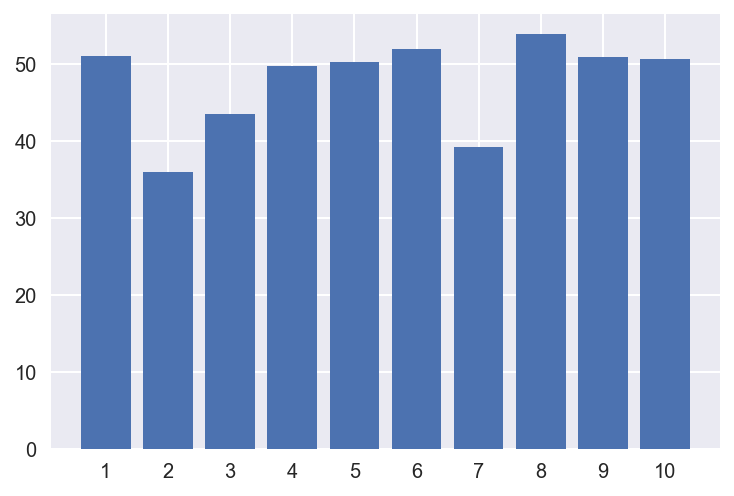

In [63]:
# 3. 
z = []
for i in range(1, 11):
    z.append(i)
print("샘플 평균 :", np.mean(result))
plt.bar(z, result)
plt.xticks(z)
plt.show()

## 중앙값
**중앙값(median)**은 전체 자료를 크기별로 정렬하였을 때 가장 중앙에 위치하게 되는 값을 말한다. 

중앙값에도 샘플 중앙값과 확률 분포로부터 계산한 이론적 중앙값이 존재한다.

- 샘플 중앙값 : 전체 샘플의 갯수가 $N$인 경우,
    - $N$ 이 홀수이면: 중간값은  (n+1)/2 번째 샘플의 값
    - $N$ 이 짝수이면: 중간값은  n/2 번째 샘플의 값과  n/2+1 번째 샘플의 값의 평균
    
- 이론적 중앙값 : 확률 분포로부터 이론적 중앙값은 그 값보다 큰 값이 나올 확률과 작은 값이 나올 확률이 동일하게 0.5이여야 한다.

$$
F(\text{median}) = 0.5 \\
\text{median} = F^{-1}(0.5)
$$

## 최빈값
**최빈값(mode)**은 가장 빈번하게 나올 수 있는 값을 말하므로 확률 밀도 함수의 값이 가장 큰 확률 변수의 값으로 정의한다. 

즉, 확률 밀도 함수의 최댓값의 위치이다.

$$
\text{mode} = \arg \max_x f(x)
$$

## 기댓값, 중앙값, 최빈값의 비교
- 확률 분포 즉, 확률 밀도 함수가 대칭인 경우에는 기댓값, 중앙값, 최빈값이 모두 같다.

- 계산량으로 비교하면 기댓값이 가장 계산하기 쉽고 중앙값은 계산량이 기댓값보다 증가하며 최빈값은 최적화 과정을 통해서만 구할 수 있으므로 계산량이 가장 많으며 오차가 크다.

- 기댓값은 이상값(outliner)이나 한쪽으로 찌그러진 상태에 큰 영향을 받지만 중앙값이나 최빈값은 이에 대한 영향이 적다.

In [64]:
np.random.seed(0)
x = np.random.normal(size=1000) # 1000개의 무작위 난수 발생

In [65]:
np.mean(x), np.median(x) # 기댓값, 중앙값

(-0.045256707490195384, -0.058028034799627745)

In [70]:
ns, bins = np.histogram(x, bins=np.linspace(-10,10,20)) # 확률 밀도 함수 발생 
print(ns, bins)

[  0   0   0   0   0   0   6  54 247 426 213  52   2   0   0   0   0   0
   0] [-10.          -8.94736842  -7.89473684  -6.84210526  -5.78947368
  -4.73684211  -3.68421053  -2.63157895  -1.57894737  -0.52631579
   0.52631579   1.57894737   2.63157895   3.68421053   4.73684211
   5.78947368   6.84210526   7.89473684   8.94736842  10.        ]


In [67]:
M = np.argmax(ns)    # 최빈값  
bins[M], bins[M+1]  

(-0.526315789473685, 0.5263157894736832)

## 확률 분포의 기댓값
확률 밀도 함수를 알고 있을 경우에는 다음과 같은 수식을 사용하여 이론적인 평균을 구할 수 있다. 

이러한 이론적 평균을 확률 변수의 **기댓값(expectation)**이라고 한다. 

- 이산 확률 변수 :  $$\mu_X = \operatorname{E}[X] = \sum xP(x)$$


- 연속 확률 변수 :  $$\mu_X = \operatorname{E}[X] = \int_{-\infty}^{\infty} x f(x) dx$$

## 기댓값의 성질
- $\operatorname{E}[c] = c$


- $\operatorname{E}[cX] = c \operatorname{E}[X]$


- $\operatorname{E}[X + Y] = \operatorname{E}[X] + \operatorname{E}[Y]$

## 기댓값과 샘플 평균의 관계
$$
\operatorname{E}[ \bar{X} ] = \operatorname{E}[X]
$$


(증명)
$$
\begin{eqnarray}
\operatorname{E}[\bar{X}] 
&=& \operatorname{E}\left[\dfrac{1}{N}\sum_{1}^{N}X_i \right]  \\
&=& \dfrac{1}{N}\sum_{1}^{N}\operatorname{E}[X_i]  \\
&=& \dfrac{1}{N}\sum_{1}^{N}\operatorname{E}[X]  \\
&=& \dfrac{1}{N} N \operatorname{E}[X] \\ 
&=& \operatorname{E}[X]  \\
\end{eqnarray}
$$

# 분산과 표준 편차
평균이나 기댓값이 분포의 위치를 대표하는 것이라면 **분산(variance)**은 분포의 폭(width)을 대표하는 값이다. 

**표준 편차(standard deviation)**는 분산에 대한 양의 제곱근(square root)값이다.

$$\text{표준 편차} = \sqrt{\text{분산}}$$

## 샘플 분산
$$s^2 = \dfrac{1}{N}\sum_{i=1}^{N} (x_i-m)^2$$
- $x_i$ : $N$개의 자료 중 $i$번재의 자료
- $m$ : 샘플 평균

**비편향 샘플 분산(unbiased sample variance)** : $$s^2_{\text{unbiased}} = \dfrac{1}{N-1}\sum_{i=1}^{N} (x_i-m)^2$$

## 확률 분포의 분산
- 이산 확률 변수 : $$\sigma^2 = \text{Var}[X] = \text{E}[(X - \mu)^2] =  \sum (x - \mu)^2 P(x)$$


- 연속 확률 변수 : $$\sigma^2 = \text{Var}[X] = \text{E}[(X - \mu)^2] = \int_{-\infty}^{\infty} (x - \mu)^2 f(x)dx$$

## 분산의 성질
- $\text{Var}[X] \geq 0$


- $\text{Var}[c] = 0$


- $\text{Var}[cX] = c^2 \text{Var}[X]$

## 분산과 기댓값의 관계
$$\text{Var}[X] = \text{E}[X^2] - (\text{E}[X])^2  = \text{E}[X^2] - \mu^2$$


(증명)
$$
\begin{eqnarray}
\text{Var}[X] 
&=& \text{E}[(X - \mu)^2] \\
&=& \text{E}[X^2 - 2\mu X + \mu^2] \\
&=& \text{E}[X^2] - 2\mu\text{E}[X] + \mu^2 \\
&=& \text{E}[X^2] - 2\mu^2 + \mu^2 \\
&=& \text{E}[X^2] - \mu^2\\
\end{eqnarray}
$$

## 샘플 평균의 분산
$$\text{Var}[\bar{X}] = \dfrac{1}{N} \text{Var}[{X}]$$


(증명)
$$
\begin{eqnarray}
\text{Var}[\bar{X}] 
&=& \text{Var} \left[ \dfrac{1}{N} \sum_{i=1}^N X_i \right] \\
&=& \text{E} \left[ \left( \dfrac{1}{N} \sum_{i=1}^N X_i - \mu \right)^2 \right] \\
&=& \text{E} \left[ \left( \dfrac{1}{N} \sum_{i=1}^N X_i - \dfrac{1}{N}N\mu \right)^2 \right] \\
&=& \text{E} \left[ \left( \dfrac{1}{N} \left( \sum_{i=1}^N X_i - N\mu \right) \right)^2 \right] \\
&=& \text{E} \left[ \left( \dfrac{1}{N} \sum_{i=1}^N (X_i - \mu) \right)^2 \right] \\
&=& \text{E} \left[ \dfrac{1}{N^2} \sum_{i=1}^N \sum_{j=1}^N (X_i - \mu) (X_j - \mu)  \right] \\
&=& \dfrac{1}{N^2} \sum_{i=1}^N \sum_{j=1}^N \text{E} \left[  (X_i - \mu) (X_j - \mu)  \right] \\
\end{eqnarray}
$$

여기에서  $Xi$ 와  $Xj  ( i≠j )$가 독립일 때

$$\text{E}\left[ (X_i-\mu)(X_j-\mu) \right] = 0$$

라는 사실을 이용하면  $i=j$ 인 항, 즉 제곱항만 남는다.

$$
\begin{eqnarray}
\text{Var}[\bar{X}]
&=& \dfrac{1}{N^2} \sum_{i=1}^N \text{E} \left[ (X_i - \mu)^2 \right] \\
&=& \dfrac{1}{N^2} \sum_{i=1}^N \text{E} \left[ (X - \mu)^2 \right] \\
&=& \dfrac{1}{N^2} N \text{E} \left[ (X - \mu)^2 \right] \\
&=& \dfrac{1}{N} \text{E} \left[ (X - \mu)^2 \right] \\
&=& \dfrac{1}{N} \text{Var}[X] \\
\end{eqnarray}
$$

# 샘플 분산의 기댓값
샘플 분산  $s^2$ 의 기대값을 구하면 이론적인 분산  $σ^2$ 의  $\dfrac{N-1}{N}$  배가 된다. 증명은 생략한다.

$$\text{E}[s^2] = \dfrac{N-1}{N}\sigma^2$$


따라서 샘플 분산의 기대값이 정확하게  $σ^2$ 이 되려면 거리 제곱의 평균을 구할 때 분모가  $N$ 이 아니라  $N−1$ 이 되어야 한다.

$$
\sigma^2 
= \dfrac{N}{N-1} \text{E}[s^2] 
= \dfrac{N}{N-1} \text{E} \left[ \dfrac{1}{N} \sum (X_i-\bar{X})^2 \right] 
= \text{E} \left[ \dfrac{1}{N-1} \sum (X_i-\bar{X})^2 \right] 
= \text{E} \left[ s^2_{\text{unbiased}} \right]
$$

In [72]:
import scipy as sp
sp.random.seed(0)
x = sp.stats.norm(0, 2).rvs(1000)  # mean(평균)=0, standard deviation(표준 편차)=2

In [73]:
np.var(x)  # variance(분산)

3.896937825248617

In [74]:
np.var(x, ddof=1)  # unbiased variance(비편향 샘플 분산)

3.900838663912529

# 모멘트
기댓값, 분산 등의 특징값을 확률 분포의 **모멘트(moment)**라고 한다. 

- 1차 모멘트 =  $E[X]$  : 기댓값 (Expectation)
- 2차 모멘트 =  $E[(X−μ)^2]$  : 분산 (Variance)
- 3차 모멘트 =  $E[(X−μ)^3]$  : 스큐니스 (Skewness)
- 4차 모멘트 =  $E[(X−μ)^4]$  : 커토시스 (Kurtosis)

### 모든 차수의 모멘트 값이 같으면 같은 확률 분포이다.

샘플 모멘트 값이 유사하면 같은 확률 변수에서 나온 표본 데이터일 가능성이 높다.

유니 모달(uni-modal) 분포인 경우 4차 모멘트까지 같으면 실용적으로 같은 분포라고 볼 수 있다.